# Southern Ocean Meridional Overturning Circulation (SOMOC)

In [1]:
import numpy as np
import xarray as xr
import glob
from om4labs.m6plot.formatting import VerticalSplitScale
import matplotlib.pyplot as plt
%matplotlib inline

/nbhome/jet/miniconda3/envs/python39/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.0-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Load interim datasets

In [2]:
outdir='/work/jet/data/interim/'

mods = ['CM4_historical_c192_OM4p25', 'CM4_historical_c192_OM4p125']
dsets = ['moc_z_annual','moc_rho2_online_%s','depth_rho2_online_%s', 'moc_rho2_online_mean_%s_reprojected', 'sigma2_jmd95_zmean']
varnames = ['psi_z', 'psi', 'depth', 'psiz', 'sigma2']
tprds = ['1920to1939']

ddict = {mod:{} for mod in mods}

for i, mod in enumerate(ddict):
    nrho = 'lores' if mod=='CM4_ssp245_251' else 'hires'
    
    for j, dset in enumerate(dsets):
        if varnames[j] in ['psi_z', 'psi', 'depth']:
            if varnames[j] in ['psi', 'depth']:
                files = glob.glob(outdir+mod+'_global_*_'+dset%nrho+'.nc')
            else:
                files = glob.glob(outdir+mod+'_global_*_'+dset+'.nc')
            if len(files)>1:
                print('WARNING: More than one file for '+dset+' in '+mod)
            elif len(files)==0:
                print('ERROR: No file available for '+dset+' in '+mod)
                continue
            print('Loading '+files[0])
            ddict[mod][varnames[j]] = xr.open_dataset(files[0])[varnames[j][:3] if varnames[j][:3]=='psi' else varnames[j].title()]
        else:
            das = []
            for k, tprd in enumerate(tprds):
                files = glob.glob(outdir+mod+'_global_'+tprd+'_%s.nc'%(dset%nrho if varnames[j]=='psiz' else dset))
                if len(files)>1:
                    print('WARNING: More than one file for '+dset+' in '+mod)
                elif len(files)==0:
                    print('ERROR: No file available for '+dset+' in '+mod)
                    continue
                    
                print('Loading '+files[0])
                da = xr.open_dataset(files[0])[varnames[j] if varnames[j]=='sigma2' else 'psi']
                da['tprd'] = tprd
                das.append(da)
            ddict[mod][varnames[j]] = xr.concat(das, dim='tprd')

Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_global_1850to2009_moc_z_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_global_1850to2009_moc_rho2_online_hires.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_global_1850to2009_depth_rho2_online_hires.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_global_1920to1939_moc_rho2_online_mean_hires_reprojected.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_global_1920to1939_sigma2_jmd95_zmean.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_global_1850to1939_moc_z_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_global_1850to1939_moc_rho2_online_hires.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_global_1850to1939_depth_rho2_online_hires.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_global_1920to1939_moc_rho2_online_mean_hires_reprojected.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_global_1920

## 2-by-3 Figure
`CM4_historical_c192_OM4p25` versus `CM4_historical_c192_OM4p125` in **z**, **rho2** and **rho2 reprojected to z**
- Use most recent common 20-year time period (1920 to 1939)

CM4_historical_c192_OM4p25 psi_z
CM4_historical_c192_OM4p25 psi
CM4_historical_c192_OM4p25 depth
CM4_historical_c192_OM4p125 psi_z
CM4_historical_c192_OM4p125 psi
CM4_historical_c192_OM4p125 depth


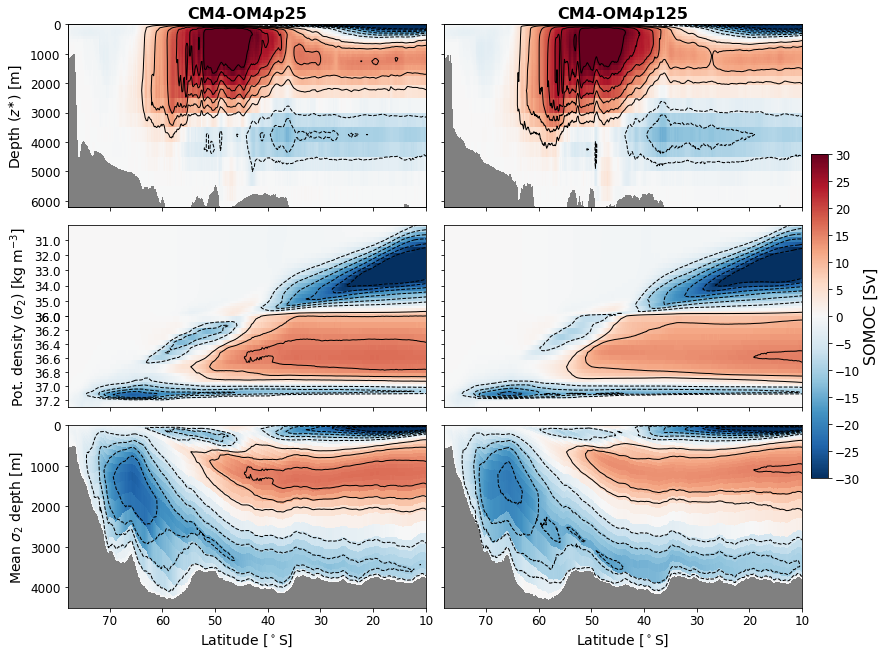

In [3]:
tprd = '1920to1939'

fig, axs = plt.subplots(ncols=2, nrows=3, sharey=False, sharex=True, figsize=[12, 9])
fig.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.05, hspace=0.1)

for i, mod in enumerate(ddict):
    for j, var in enumerate(varnames[:3]):
        print(mod,var)
    
        
        if var in ['psi_z', 'psi']:
            da = ddict[mod][var].sel(time=slice(tprd.split('to')[0],tprd.split('to')[-1]))
        else:
            z_rho2 = ddict[mod][var].sel(time=slice(tprd.split('to')[0],tprd.split('to')[-1])).mean('time')
            da = ddict[mod]['psi'].sel(time=slice(tprd.split('to')[0],tprd.split('to')[-1]))
            da.coords['depth'] = z_rho2
        
        if var=='psi_z':
            da.mean('time').plot(ax=axs[j,i], yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                                 add_labels=False, add_colorbar=False)
            da.mean('time').plot.contour(ax=axs[j,i], yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                                         colors='k', linewidths=1, add_labels=False)
            axs[j,i].set_ylim((6200,0))
            
            topomask = xr.open_dataset('/work/jet/static/%s_topomask.nc'%mod.split('_')[-1][3:]).topomask
            ax2 = axs[j,i].twinx()
            topomask.sel(yh=slice(None,0)).plot(ax=ax2, x='yh', y='z', cmap='gray', shading='auto', 
                                                add_colorbar=False, add_labels=False)
            ax2.set_xlim((-78,-10))
            ax2.set_ylim((6200,0))
            ax2.get_yaxis().set_ticks([])
        
            if i==0:
                axs[j,i].set_ylabel(r'Depth ($z^{\ast}$) [m]', fontsize=14)
            else:
                axs[j,i].set_yticklabels([])
            
        elif var=='psi':
            p = da.mean('time').sel(rho2_i=slice(1026.5,None)).plot(ax=axs[j,i], yincrease=False,vmin=-30,vmax=30,
                                                                    cmap='RdBu_r',add_colorbar=False, add_labels=False)
            da.mean('time').sel(rho2_i=slice(1026.5,None)).plot.contour(ax=axs[j,i], yincrease=False, 
                                                                        levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                                                                        colors='k', linewidths=1, add_labels=False)
            axs[j,i].set_yscale('splitscale', zval=[1037.3, 1036, 1030])
            axs[j,i].invert_yaxis()
            yticks = axs[j,i].get_yticks()
            #print(yticks)
            
            if i==0:
                axs[j,i].set_ylabel(r'Pot. density ($\sigma_2$) [kg m$^{-3}$]', fontsize=14)
                axs[j,i].set_yticklabels([str(tick) for tick in np.round(yticks-1000,2)])
            else:
                axs[j,i].set_yticklabels([])
                
            
        else:
            p = da.mean('time').plot(ax=axs[j,i], x='yq', y='depth', yincrease=False,vmin=-30, vmax=30, cmap='RdBu_r',
                                     add_colorbar=False, add_labels=False)
            da.mean('time').plot.contour(ax=axs[j,i], x='yq', y='depth', yincrease=False, 
                                  levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                                  colors='k', linewidths=1, add_labels=False)
            axs[j,i].set_ylim((4500,0))
            
            if i==0:
                axs[j,i].set_ylabel(r'Mean $\sigma_2$ depth [m]', fontsize=14)
            else:
                axs[j,i].set_yticklabels([])
            
        axs[j,i].set_xlim((-78,-10))
        axs[j,i].set_xticks(np.arange(-70,0,10))
        axs[j,i].set_xticklabels(np.arange(70,0,-10))
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        axs[j,i].set_facecolor('gray')
        
        if j==0:
            axs[j,i].set_title(mod.replace('_historical_c192_', '-'),fontsize=16, fontweight='bold')
        elif j==2:
            axs[j,i].set_xlabel(r'Latitude [$^\circ$S]', fontsize=14)
        

cax = fig.add_axes([0.91, 0.25, 0.02, 0.50])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-30,35,5), orientation='vertical', shrink=0.9, pad=0.01)
cb.set_label(r'SOMOC [Sv]', fontsize=16)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()